# Compare different similarity methods

- Pocket structure similarity (`kissim`)
- Pocket sequence identity (KLIFS seq)
- Interaction similarity (KLIFS IFP)
- Compare matrices!

Resources:

- [SciPy: Jaccard distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jaccard.html#scipy.spatial.distance.jaccard)
- [Scikit-Learn: Pairwise distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from opencadd.databases import klifs

import src
from src.paths import PATH_DATA, PATH_RESULTS
from src.utils import check_distance_matrix

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_DATA
RESULTS = PATH_RESULTS

In [4]:
klifs_session = klifs.setup_remote()

In [5]:
def min_max_normalize_df(df):
    df = (df - df.min().min()) / (df.max().max() - df.min().min())
    return df

## Pocket structure similarity: `kissim`

### Kinase matrix

In [6]:
%%time
kissim_matrix = src.data.distances.kissim()

CPU times: user 31.3 s, sys: 1.45 s, total: 32.8 s
Wall time: 32.8 s


### Get kinases and structure KLIFS IDs from `kissim` dataset

#### Kinase names

In [7]:
kinase_names = kissim_matrix.columns.to_list()
print(f"Number of kinase names: {len(kinase_names)}")

Number of kinase names: 257


#### Kinase KLIFS IDs

In [8]:
kinases = klifs_session.kinases.by_kinase_name(kinase_names, species="Human")
# Make sure the DataFrame is ordered by kinase names in list
kinases = kinases.set_index("kinase.klifs_name").loc[kinase_names].reset_index()
kinase_klifs_ids = kinases["kinase.klifs_id"].to_list()
print(f"Number of kinase KLIFS IDs: {len(kinase_klifs_ids)}")

Number of kinase KLIFS IDs: 257


#### Structure KLIFS IDs

In [9]:
structures = klifs_session.structures.by_kinase_klifs_id(kinase_klifs_ids)
structure_klifs_ids = structures["structure.klifs_id"].to_list()
print(f"Number of structure KLIFS IDs: {len(structure_klifs_ids)}")

Number of structure KLIFS IDs: 11519


## Pocket sequence identity: KLIFS sequence

Settings:

- Keep full pocket sequences only (can contain gaps)
- Sequence identity!
- Matrix values: distances (not similarities)
- Min-max normalization

### Kinase matrix

In [10]:
%%time
seq_matrix = src.data.distances.klifs_pocket_sequence()

CPU times: user 362 ms, sys: 349 µs, total: 363 ms
Wall time: 538 ms


## Interaction similarity: KLIFS IFP

Settings:

- Use structures in DFG-in only
- Use Jaccard distance
- Matrix values: distances (not similarities)
- Min-max normalization

### Kinase matrix

In [11]:
%%time
ifp_matrix = src.data.distances.klifs_pocket_ifp(structure_klifs_ids)

CPU times: user 15.4 s, sys: 790 ms, total: 16.2 s
Wall time: 19.5 s


## Pocket structure similarity: SiteAlign

Settings:

- Use structures in DFG-in only
- SiteAlign encoding and comparison
- Matrix values: distances

### Kinase matrix

In [12]:
%%time
sitealign_matrix = src.data.distances.sitealign_pocket_structure()

CPU times: user 10.6 ms, sys: 139 µs, total: 10.7 ms
Wall time: 10.3 ms


## Compare matrices

### Distance matrix conditions

In [13]:
check_distance_matrix(kissim_matrix.values)

Matrix 2D and square?:        True
Matrix positive?:             False
Matrix diagonale 0?:          True
Matrix symmetric?:            False
Triangular inequality?:       False


In [14]:
check_distance_matrix(seq_matrix.values)

Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


In [15]:
check_distance_matrix(ifp_matrix.values)

Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       False


In [16]:
check_distance_matrix(sitealign_matrix.values)

Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


### Shared kinases

In [17]:
kissim_matrix.shape, seq_matrix.shape, ifp_matrix.shape, sitealign_matrix.shape

((257, 257), (521, 521), (242, 242), (256, 256))

In [18]:
kinase_names_selected = set(kissim_matrix.columns.to_list()) & set(seq_matrix.columns.to_list())
kinase_names_selected = kinase_names_selected & set(ifp_matrix.columns.to_list())
kinase_names_selected = kinase_names_selected & set(sitealign_matrix.columns.to_list())
kinase_names_selected = sorted(kinase_names_selected)
print(f"Number of shared kinases: {len(kinase_names_selected)}")

Number of shared kinases: 241


### Shared kinase distance matrix

In [19]:
kissim_matrix_shared = kissim_matrix.loc[kinase_names_selected, kinase_names_selected]
seq_matrix_shared = seq_matrix.loc[kinase_names_selected, kinase_names_selected]
ifp_matrix_shared = ifp_matrix.loc[kinase_names_selected, kinase_names_selected]
sitealign_matrix_shared = sitealign_matrix.loc[kinase_names_selected, kinase_names_selected]

print("KiSSim    ", kissim_matrix_shared.min().min(), kissim_matrix_shared.max().max())
print("Seq       ", seq_matrix_shared.min().min(), seq_matrix_shared.max().max())
print("IFP       ", ifp_matrix_shared.min().min(), ifp_matrix_shared.max().max())
print("SiteAlign ", sitealign_matrix_shared.min().min(), sitealign_matrix_shared.max().max())

KiSSim     0.0 0.1839334938542972
Seq        0.0 0.9411764705882353
IFP        0.0 0.875
SiteAlign  0.0 0.4922


### Shared normalized kinase distance matrix

In [20]:
kissim_matrix_shared_normalized = min_max_normalize_df(kissim_matrix_shared)
seq_matrix_shared_normalized = min_max_normalize_df(seq_matrix_shared)
ifp_matrix_shared_normalized = min_max_normalize_df(ifp_matrix_shared)
sitealign_matrix_shared_normalized = min_max_normalize_df(sitealign_matrix_shared)

print(
    "KiSSim    ",
    kissim_matrix_shared_normalized.min().min(),
    kissim_matrix_shared_normalized.max().max(),
)
print(
    "Seq       ",
    seq_matrix_shared_normalized.min().min(),
    seq_matrix_shared_normalized.max().max(),
)
print(
    "IFP       ",
    ifp_matrix_shared_normalized.min().min(),
    ifp_matrix_shared_normalized.max().max(),
)
print(
    "SiteAlign ",
    sitealign_matrix_shared_normalized.min().min(),
    sitealign_matrix_shared_normalized.max().max(),
)

KiSSim     0.0 1.0
Seq        0.0 1.0
IFP        0.0 1.0
SiteAlign  0.0 1.0


### Shared kinase pair distances

In [21]:
kissim_pairs = kissim_matrix_shared_normalized.to_numpy()[
    np.tril_indices(kissim_matrix_shared_normalized.to_numpy().shape[0], -1)
]
seq_pairs = seq_matrix_shared_normalized.to_numpy()[
    np.tril_indices(seq_matrix_shared_normalized.to_numpy().shape[0], -1)
]
ifp_pairs = ifp_matrix_shared_normalized.to_numpy()[
    np.tril_indices(ifp_matrix_shared_normalized.to_numpy().shape[0], -1)
]
sitealign_pairs = sitealign_matrix_shared_normalized.to_numpy()[
    np.tril_indices(sitealign_matrix_shared_normalized.to_numpy().shape[0], -1)
]

pair_distances_df = pd.DataFrame(
    {
        "KiSSim": kissim_pairs,
        "KLIFS pocket sequence": seq_pairs,
        "KLIFS pocket IFP": ifp_pairs,
        "SiteAlign pocket structure": sitealign_pairs,
    }
)
pair_distances_df.head()

,KiSSim,KLIFS pocket sequence,KLIFS pocket IFP,SiteAlign pocket structure
0,0.582394,0.7750,0.300752,0.474604
1,0.607425,0.7875,0.571429,0.564202
2,0.062204,0.0500,0.049689,0.069281
3,0.592332,0.7625,0.428571,0.506298
4,0.358829,0.4875,0.285714,0.340106


### Plot distributions

- https://seaborn.pydata.org/tutorial/distributions.html
- https://seaborn.pydata.org/generated/seaborn.pairplot.html

In [22]:
def annotate(x, y, ax):
    """
    Annotate axes with correlation coefficient.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    """
    r, p = scipy.stats.pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={round(r, 2)}", transform=ax.transAxes)

CPU times: user 2min 3s, sys: 1.96 s, total: 2min 5s
Wall time: 2min 2s


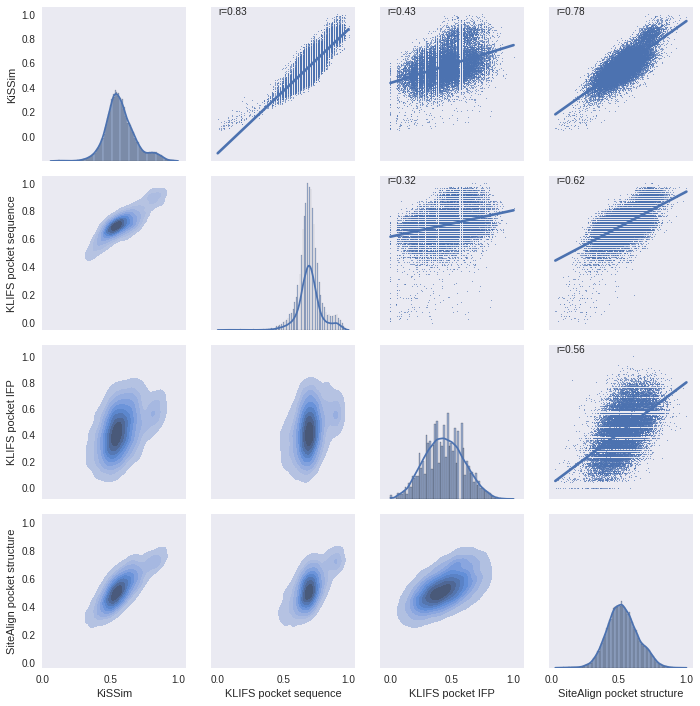

In [23]:
%%time

g = sns.PairGrid(pair_distances_df)
# Turn off grid
for axes in g.axes:
    for ax in axes:
        ax.grid(False)

g.map_upper(sns.regplot, scatter_kws={"s": 1}, ci=95)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Annotate

# First row
tmp = pair_distances_df[["KiSSim", "KLIFS pocket sequence"]].dropna()
annotate(tmp["KiSSim"], tmp["KLIFS pocket sequence"], g.axes[0][1])
tmp = pair_distances_df[["KiSSim", "KLIFS pocket IFP"]].dropna()
annotate(tmp["KiSSim"], tmp["KLIFS pocket IFP"], g.axes[0][2])
tmp = pair_distances_df[["KiSSim", "SiteAlign pocket structure"]].dropna()
annotate(tmp["KiSSim"], tmp["SiteAlign pocket structure"], g.axes[0][3])

# Second row
tmp = pair_distances_df[["KLIFS pocket sequence", "KLIFS pocket IFP"]].dropna()
annotate(tmp["KLIFS pocket sequence"], tmp["KLIFS pocket IFP"], g.axes[1][2])
tmp = pair_distances_df[["KLIFS pocket sequence", "SiteAlign pocket structure"]].dropna()
annotate(tmp["KLIFS pocket sequence"], tmp["SiteAlign pocket structure"], g.axes[1][3])

# Third row
tmp = pair_distances_df[["KLIFS pocket IFP", "SiteAlign pocket structure"]].dropna()
annotate(tmp["KLIFS pocket IFP"], tmp["SiteAlign pocket structure"], g.axes[2][3])

g.savefig(HERE / "../../notebooks/figures/figX_method_comparison_pairplots.pdf")